In [2]:
import os
import zipfile
from urllib import request

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse
import scipy.spatial

In [3]:
def load_movielens_ratings(input_file):
    """
    Read movielens ratings
    input_file: ratings file path
    returns: pandas dataframe: user_id, item_id, rating, timestamp
    """
    schema = {
        'user_id': np.int32,
        'item_id': np.int32,
        'rating': np.float32,
        'timestamp': np.int32,
    }
    columns = schema.keys() # keys order preserving added but not guaranted in python 3.6
    ratings_df = pd.read_csv(input_file, sep='\t', header=None, names=columns, dtype=schema)
    
    # Movielens dataset has matlab index, so we convert it to 0-indexing
    ratings_df.user_id = ratings_df.user_id.sub(1)
    ratings_df.item_id = ratings_df.item_id.sub(1)
    
    return ratings_df

def load_movies_descriptions(input_file):
    """
    Read movie ids and titles
    input_file: ratings file path
    returns: pandas dataframe: item_id, item_name
    """
    schema = {
        'item_id': np.int32,
        'item_name': str, 
    }
    columns = schema.keys()
    descriptions_df = pd.read_csv(input_file, sep='|', header=None, usecols=(0, 1),
                                  encoding="latin1", names=columns, dtype=schema)
    descriptions_df.item_id = descriptions_df.item_id.sub(1)
    
    return descriptions_df.set_index('item_id')

def ratings_to_matrix(ratings_df, user_col, item_col, rating_col, forced_shape=None):
    """
    Convert ratings datafrem into numpy matrix
    ratings_df: pandas dataframe with COO format ratings
    user_col: index of user id column
    item_col: index of item id column
    rating_col: index of rating column
    forced_shape: set shape of output matrix if forced_shape is greater than infered
    returns: numpy array of ratings with user ratings in rows and item in columns
    """
    users_num = ratings_df.user_id.max() + 1
    items_num = ratings_df.item_id.max() + 1
    
    if forced_shape:
        users_num = max(users_num, forced_shape[0])
        items_num = max(items_num, forced_shape[1])
    
    ratings_mat = np.zeros([users_num, items_num])
    for rating in ratings_df.itertuples():
        ratings_mat[rating[user_col], rating[item_col]] = rating[rating_col]
    
    return ratings_mat

In [21]:
class MFModel:
    def __init__(self, user_factors, item_factors):
        """
        Model for recommendations based on matrix factorization
        user_factors: numpy array of users_num, rank shape
        item_factors: numpy array of items_num, rank shape
        """
        self._user_factors = np.copy(user_factors)
        self._item_factors = np.copy(item_factors)
        
        self._users_num = user_factors.shape[0]
        self._items_num = item_factors.shape[0]

        assert user_factors.shape[1] == item_factors.shape[1]
        
    def predict(self, user_id, item_id):
        """
        Calculate rating for user, item pair
        user_id: int
        item_id: int
        returns: float rating for given pair of ids
        """
        # DONEreturn prediction for given pair
        return self._user_factors[user_id, : ].dot(self._item_factors[item_id, :])
    
    def predict_all(self):
        """
        Generate full prediction matrix
        returns: numpy array with predictions for all user, item pairs
        """
        # DONE return prediction for all users
        return self._user_factors.dot(self._item_factors.T)
        
    def similar_items(self, item_id, metric, k):
        """
        Find similiar items to given one
        item_id: int, for which item recommendations should be generated
        metric: string, metric name
        k: int, limit items to the k closest
        returns: ids of similar items
        """
        # DONE calculate similarity of items to given one
        # Return k most similar
        distances = scipy.spatial.distance.cdist(np.atleast_2d(self._item_factors[item_id, :]), self._item_factors, metric)
        return distances.argsort()[0, :k]
    
class ALS:
    def __init__(self, ratings, rank, user_reg_loss, item_reg_loss):
        """
        Create generator for ALS matrix factorization
        ratings: numpy array of rating values
        rank: int, number of latent factors in user and item matrix
        user_reg_loss: float, regularization factor for user latent factors
        item_reg_loss: float, regularization factor for item latent factors
        """
        self._ratings = ratings
        self._users_num, self._items_num = ratings.shape
        self._rank = rank
        self._user_reg_loss = user_reg_loss
        self._item_reg_loss = item_reg_loss
        
        self._train_function = self._als_partial_step_explicit
        
        # DONE init latent factors for user and item matrix
        # losowo ustalamy inicjalne wartości X i Y
        self._user_factors = np.random.random((self._users_num, rank))
        self._item_factors = np.random.random((self._items_num, rank))
        
        
    def train(self, iters_num):
        """
        Update factors
        iters_num: number of iterations
        returns: MFModel of the ALS current state
        """
        # DONE run alternetly user and item matrices factorization
        # Return new MFModel
        for _ in range(iters_num):
            self._als_partial_step_explicit(True)
            self._als_partial_step_explicit(False)
        
        return MFModel(self._user_factors, self._item_factors)
        
    def _als_partial_step_explicit(self, user_mode):
        """
        Update user/item latent factors
        user_mode: if true, update user factors
        returns: None
        """
        # DONE minmize loss function and update factors
        # Loss = (R - X * Y^T)^2 + λ_x * ||X||^2 + λ_y * ||Y||^2
        # X = ((Y^T * Y) + λ_x * I)^-1 * (R * Y) for dLoss / dX == 0
        # Useful functions: np.linalg.inv or np.linalg.solve
        if user_mode:
            fixed_factors = self._item_factors
            updated_factors = self._user_factors
            ratings = self._ratings
            reg_loss = self._user_reg_loss
        else:
            fixed_factors = self._user_factors
            updated_factors = self._item_factors
            ratings = self._ratings.T
            reg_loss = self._item_reg_loss
        
        A = (fixed_factors.T).dot(fixed_factors)
        A += np.eye(A.shape[0]) * reg_loss
        
        B = ratings.dot(fixed_factors)
        
        
        for row in range(updated_factors.shape[0]):
            updated_factors[row, : ] = np.linalg.solve(A, B[row])
            
            

In [18]:
matrix_shape = [943, 1682]
ratings_df = load_movielens_ratings('ml-100k/u.data')
ratings = ratings_to_matrix(ratings_df, 1, 2, 3, matrix_shape)
descriptions = load_movies_descriptions('ml-100k/u.item')

# TODO select parameters for first run
als = ALS(ratings, 30, 1, 1)
model = als.train(40)

# TODO, you can check most similar movies to given one
movie_id = 201
similarity_metric = 'cos'
rec_num = 10
similar_items = pd.DataFrame(model.similar_items(movie_id, similarity_metric, rec_num), 
                             columns=['item_id'], dtype=np.int32).set_index('item_id')
print(similar_items.join(descriptions, 'item_id'))

                                         item_name
item_id                                           
201                           Groundhog Day (1993)
203                      Back to the Future (1985)
215                 When Harry Met Sally... (1989)
731                                    Dave (1993)
172                     Princess Bride, The (1987)
87                     Sleepless in Seattle (1993)
238                                Sneakers (1992)
167         Monty Python and the Holy Grail (1974)
209      Indiana Jones and the Last Crusade (1989)
68                             Forrest Gump (1994)


In [19]:
# omit warnings thrown on 0 division, numpy fills result with NAN instead
np.seterr(divide='ignore', invalid='ignore')

def precision_at_k(model, ratings, k, relevance_func):
    """
    Calculate precision@k for predictions
    model: trained MFModel
    ratings: numpy array of ratings for which metric should be calculated
    k: int, how many items should be recommended
    relevance_func: callable, definition of relevant rating eg. (lambda x: x >= 3)
    returns: float, mean precision at k
    """
    predictions = model.predict_all()
    np.place(predictions, ratings == 0, -np.Inf)
    recommended = predictions.argsort(1)[::, :-k-1:-1]
    
    relevance_per_user = np.take_along_axis(ratings, recommended, 1)
    max_relevance_per_user = (relevance_per_user > 0).sum(1)
    relevance_per_user = relevance_func(relevance_per_user).sum(1)

    precision = np.divide(relevance_per_user, max_relevance_per_user)
    
    return np.nanmean(precision)
    
def recall_at_k(model, ratings, k, relevance_func):
    """
    Calculate recall@k for predictions
    model: trained MFModel
    ratings: numpy array of ratings for which metric should be calculated
    k: int, how many items should be recommended
    relevance_func: callable, definition of relevant rating eg. (lambda x: x >= 3)
    returns: float, mean recall at k
    """
    predictions = model.predict_all()
    np.place(predictions, ratings == 0, -np.Inf)
    recommended = predictions.argsort(1)[::, :-k-1:-1]
    
    relevance_per_user = np.take_along_axis(ratings, recommended, 1)
    relevance_per_user = relevance_func(relevance_per_user).sum(1)
    
    max_relevance_per_user = relevance_func(ratings)
    max_relevance_per_user = max_relevance_per_user.sum(1).clip(0, k)
    
    recall = np.divide(relevance_per_user, max_relevance_per_user)
    
    return np.nanmean(recall)
    
def rmse(model, ratings):
    """
    Calculate RMSE for predictions
    model: trained MFModel
    ratings: numpy array of ratings for which metric should be calculated
    returns: float, RMSE
    """
    predictions = model.predict_all().clip(1, 5)
    predictions = predictions[ratings.nonzero()]
    true_values = ratings[ratings.nonzero()]
    
    return np.sqrt(np.mean((predictions - true_values)**2))

rank: 3, user_reg_loss: 0, item_reg_loss: 0, train_metric: 2.417862307943743, test_metric: 2.5420549117757067
rank: 3, user_reg_loss: 0, item_reg_loss: 0.1, train_metric: 2.4192183500572595, test_metric: 2.5430685945353644
rank: 3, user_reg_loss: 0, item_reg_loss: 1, train_metric: 2.423657699370346, test_metric: 2.5464977694777695
rank: 3, user_reg_loss: 0, item_reg_loss: 10, train_metric: 2.4276290435542895, test_metric: 2.5496180592722655
rank: 3, user_reg_loss: 0.1, item_reg_loss: 0, train_metric: 2.4178619428122667, test_metric: 2.5420545252756677
rank: 3, user_reg_loss: 0.1, item_reg_loss: 0.1, train_metric: 2.4192250118310614, test_metric: 2.543075220021046
rank: 3, user_reg_loss: 0.1, item_reg_loss: 1, train_metric: 2.423651275096165, test_metric: 2.5464762014916236
rank: 3, user_reg_loss: 0.1, item_reg_loss: 10, train_metric: 2.4277523400607866, test_metric: 2.5497144128455975
rank: 3, user_reg_loss: 1, item_reg_loss: 0, train_metric: 2.417862303148275, test_metric: 2.542054906

rank: 50, user_reg_loss: 1, item_reg_loss: 1, train_metric: 1.8926908920809467, test_metric: 2.565398776748867
rank: 50, user_reg_loss: 1, item_reg_loss: 10, train_metric: 1.9071425130721948, test_metric: 2.5683654228667656
rank: 50, user_reg_loss: 10, item_reg_loss: 0, train_metric: 1.8766423120350642, test_metric: 2.5590242052807013
rank: 50, user_reg_loss: 10, item_reg_loss: 0.1, train_metric: 1.8855295834870567, test_metric: 2.5610037745146923
rank: 50, user_reg_loss: 10, item_reg_loss: 1, train_metric: 1.9044260779569875, test_metric: 2.566342375321722
rank: 50, user_reg_loss: 10, item_reg_loss: 10, train_metric: 1.9566700537023027, test_metric: 2.5743864054452197
rank: 100, user_reg_loss: 0, item_reg_loss: 0, train_metric: 1.5352034292296335, test_metric: 2.6693091946902476
rank: 100, user_reg_loss: 0, item_reg_loss: 0.1, train_metric: 1.543209702701498, test_metric: 2.6704470967691734
rank: 100, user_reg_loss: 0, item_reg_loss: 1, train_metric: 1.5511555784550046, test_metric: 2

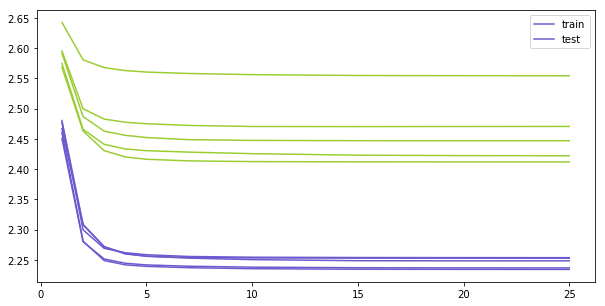

In [22]:
def generate_lerning_curves(trainable, checkpoints, train, test, metric_func, *metric_args, **metric_kwargs):
    train_metric = []
    test_metric = []
    
    prev_checkpoint = checkpoints[0] - 1
    for checkpoint in checkpoints:
        model = trainable.train(checkpoint - prev_checkpoint)
        train_metric.append(metric_func(model, train, *metric_args, **metric_kwargs))
        test_metric.append(metric_func(model, test, *metric_args, **metric_kwargs))
        prev_checkpoint = checkpoint

    return np.array(train_metric), np.array(test_metric)

train_curves = []
test_curves = []
min_settings = (np.inf, None,  None, None) # Record best and worst score, hyperparameters and lerning curves
max_settings = (-np.inf, None, None, None)

checkpoints = [1, 2, 3, 4, 5, 7, 10, 15, 20, 25]

for rank in [3, 5, 10, 20, 50, 100]: # TODO fill rank values
    for user_reg_loss in [0, 0.1, 1, 10]: # TODO fill user/item regression loss
        for item_reg_loss in [0, 0.1, 1, 10]:
            train_metric = 0
            test_metric = 0
            
            for i in range(1, 6):
                train_df = load_movielens_ratings(f'ml-100k/u{i}.base')
                test_df = load_movielens_ratings(f'ml-100k/u{i}.test')
                train = ratings_to_matrix(train_df, 1, 2, 3, matrix_shape)
                test = ratings_to_matrix(test_df, 1, 2, 3, matrix_shape)

                als = ALS(train, rank, user_reg_loss, item_reg_loss)

                train_curve, test_curve = generate_lerning_curves(als, checkpoints, train, test, rmse)
                train_curves.append(train_curve)
                test_curves.append(test_curve)

                train_metric += train_curves[-1][-1] # get final score
                test_metric += test_curves[-1][-1]
            
            train_metric /= 5
            test_metric /= 5
            
            if test_metric > max_settings[0]:
                max_settings = (test_metric, (rank, user_reg_loss, item_reg_loss), train_curves[-5:], test_curves[-5:])
            if test_metric < min_settings[0]:
                min_settings = (test_metric, (rank, user_reg_loss, item_reg_loss), train_curves[-5:], test_curves[-5:])
            
            print(f'rank: {rank}, user_reg_loss: {user_reg_loss}, item_reg_loss: {item_reg_loss}, '
                  f'train_metric: {train_metric}, test_metric: {test_metric}')

colors = ['slateblue', 'yellowgreen']
plt.rcParams['figure.figsize'] = [10, 5]

# Show best and worst score (order depends on metric)
print(max_settings[0], max_settings[1])
print(min_settings[0], min_settings[1])

for curve in min_settings[2]:
    plt.plot(checkpoints, curve, colors[0])

for curve in min_settings[3]:
    plt.plot(checkpoints, curve, colors[1])

plt.legend(['train', 'test'])
plt.show()